# Multi-Objective Optimization
Non-dominated sorted Genetic Algorithm (NSGA-II)

In [27]:
import numpy as np
from numpy.random import uniform, seed
import matplotlib.pyplot as plt
from random import sample
from copy import deepcopy 
from time import sleep, time
import pandas as pd
from random import sample, choice, shuffle, gauss
from math import cos, pi
from copy import deepcopy

In [6]:
def cost(x):
    x[0] *= 180
    df = pd.DataFrame(data=x, columns=['vars'])
    df.to_csv('variables.csv')
    
    sleep(1)
    
    cost = pd.read_csv('from_grasshopper.csv')
    
    return cost['cost'][0]

In [5]:
a = np.array([1,2,4])
cost(a)

array([0.9999991, 1.       ])

In [21]:
t = []
for i in np.linspace(-4,4,50):
    for j in np.linspace(-4,4,50):
        for k in np.linspace(-4,4,50):
            t.append(cost(np.array([i,j,k])))

In [22]:
t = np.array(t)

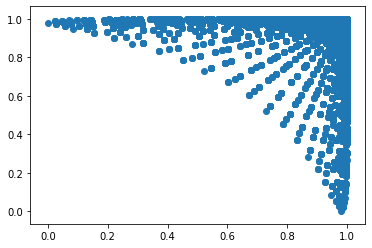

In [23]:
plt.scatter(t[:,0], t[:,1])
plt.show()

### Problem Definition

In [24]:
costFunction = cost

nGene = 3
geneDomain = [-4,4]
geneMin = -4
geneMax = 4

nObjectives = 2

### NSGA-II Parameters

In [25]:
nGeneration = 200

population_size = 50

nCrossover = 34
nMutation = 10

# crossover hyperparameter
alpha = 0.5

### Initialization

In [39]:
class Agent:
    _pop = []
    
    def __init__(self, genome=None):
        if genome:
            self.genome = np.array(genome)
        else:
            self.genome = uniform(geneMin, geneMax, nGene)
        
        # compute the f(X) = fitness
        self.fitness = costFunction(self.genome)
        self._pop.append(self)
    
    @classmethod
    def run(cls):
        # generate random agents (initialization)
        for _ in range(population_size): 
            cls()
        
        # random selection & crossover
        candidates = sample(cls._pop, nCrossover)

        for i in range(0,nCrossover,2):
            parent1 = candidates[i]
            parent2 = candidates[i+1]
            parent1.blend_crossover(parent2)

        # random selection & mutation
        candidates = sample(cls._pop, nMutation)
        for i in candidates:
            i.mutate()
    
        # merge 
        # the merge happen inside the initializer
        
        # compute non-dominated sorting
        ndf = cls.non_dominated_sorting()
        
        # compute the crowding distance
        cls.cd(ndf)
        
        # sort population
        cls.sort_population()
        
        # truncate
        cls._pop = cls._pop[:population_size]
        
        # filter first front
        first_front = np.array([i.fitness for i in cls._pop if i.rank==1])
        
        
        # plot the costs
        plt.scatter(first_front[:,0], first_front[:,1])
        first_front = np.array(sorted(first_front, key=lambda t: t[0]))
        plt.plot(first_front[:,0], first_front[:,1], 'r--')
        plt.show()
    
    
    
    @classmethod
    def cd(cls, fronts):
        for i in cls._pop:
            i.crowding_distance = None
        
        for front in fronts.values():
            n = len(front)
            
            if n>1 :
                costs = np.vstack([cls._pop[front[k]].fitness for k in range(n)])
                d = np.zeros((n, nObjectives))

                for j in range(nObjectives):
                    c, idx = np.sort(costs[:,j]), np.argsort(costs[:,j])
                    
                    # the first and last items in a front have inf distance

                    d[idx[0]][j] = np.inf
                    d[idx[-1]][j] = np.inf
                    
                    for i in range(1,n-1):
                        d[idx[i]][j] = np.abs(c[i+1] - c[i-1]) / np.abs(c[0] - c[-1])
                
                for i,j in enumerate(front):
                   cls._pop[j].crowding_distance = np.sum(d[i,:])
            else:
                cls._pop[front[0]].crowding_distance = np.inf
    
    
    @classmethod
    def non_dominated_sorting(cls):
        c = 1
        locals()[f"front{c}"] = []
        n = len(cls._pop)
        
        for i in cls._pop:
            # each object receives three new attributes 
            # (domination list, dominated count, rank)
            i.domination_list = []
            i.dominated_count = 0
            i.rank = None
        
        
        for i in range(n):
            for j in range(i+1,n):
                data1 = cls._pop[i]
                data2 = cls._pop[j]
                
                if all(data1.fitness <= data2.fitness) & any(data1.fitness < data2.fitness):
                    # it means that data1 is dominating data2
                    data1.domination_list.append(j)
                    data2.dominated_count += 1
                elif all(data2.fitness <= data1.fitness) & any(data2.fitness < data1.fitness):
                    # it means that data2 is dominating data1
                    data2.domination_list.append(i)
                    data1.dominated_count += 1
    
            if cls._pop[i].dominated_count == 0:
                locals()[f"front{c}"].append(i)
                cls._pop[i].rank = c
        
        while True:
            locals()[f"front{c+1}"] = []
            for i in locals()[f"front{c}"]:
                data1 = cls._pop[i]
                for j in data1.domination_list:
                    data2 = cls._pop[j]
                    
                    data2.dominated_count -= 1
                    if data2.dominated_count == 0:
                        locals()[f"front{c+1}"].append(j)
                        data2.rank = c+1
            
            if len(locals()[f"front{c+1}"])==0:
                del locals()[f"front{c+1}"]
                break
            c += 1
        
        del c, cls, data1, data2, n, i, j
        return locals()
        
    
    
    @classmethod
    def sort_population(cls):
        # first we sort based on Crowding Distance and then we sort 
        # based on rank
        cls._pop = sorted(cls._pop, key=lambda t: t.crowding_distance, reverse=True)
        cls._pop = sorted(cls._pop, key=lambda t: t.rank)
    
    def blend_crossover(self,other):
        gamma = uniform(-alpha,1+alpha,nGene)
        offspring1 = gamma*self.genome + (1-gamma)*other.genome
        offspring2 = gamma*other.genome + (1-gamma)*self.genome
        
        # bound the offspring's genes to the definde domain
        offspring1[offspring1>geneMax] = geneMax
        offspring1[offspring1<geneMin] = geneMin
        offspring2[offspring2>geneMax] = geneMax
        offspring2[offspring2<geneMin] = geneMin
        
        [Agent(list(offspring1)), Agent(list(offspring2))]
        
    def mutate(self):
        temp_genome = deepcopy(self.genome)
        # increasing the number 10 means more exploitation (its a hyper-parameter)
        sigma = geneDomain[1] - geneDomain[0] / 10
        temp_genome[np.random.randint(0,nGene)] += np.random.normal(0,sigma)
        
        # bound the offspring's genes to the definde domain
        temp_genome[temp_genome>geneDomain[1]] = geneDomain[1]
        temp_genome[temp_genome<geneDomain[0]] = geneDomain[0]
        
        Agent(list(temp_genome))

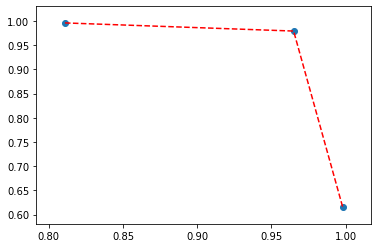

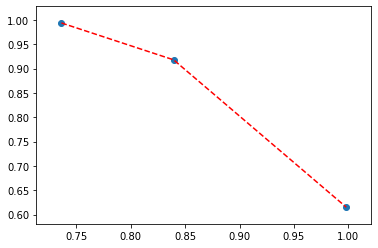

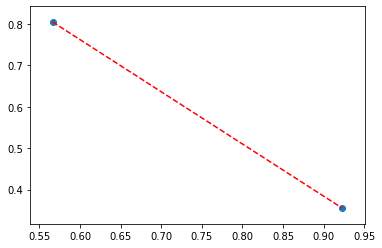

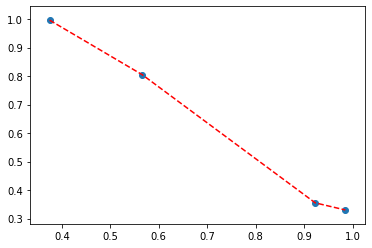

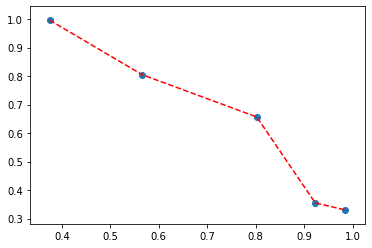

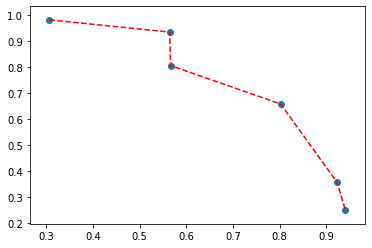

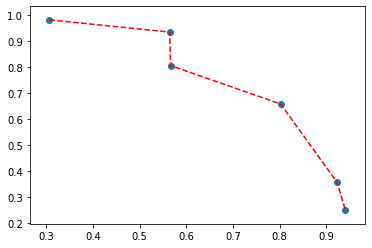

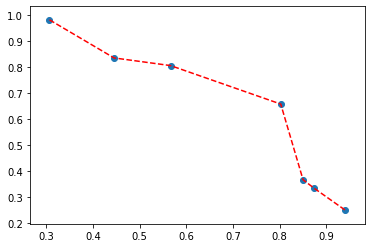

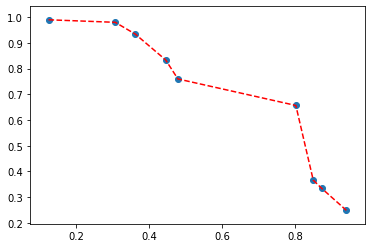

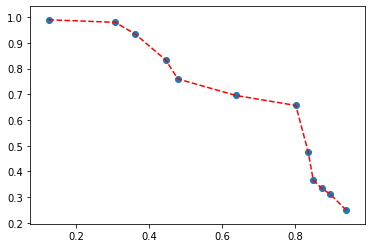

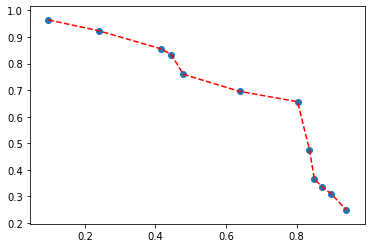

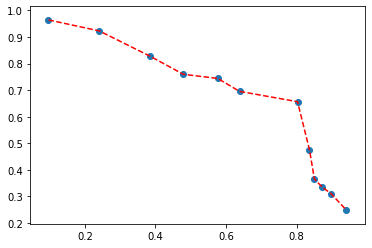

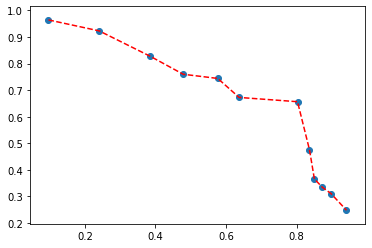

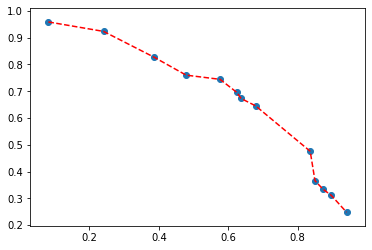

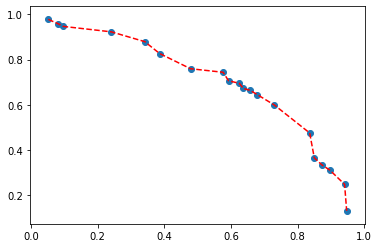

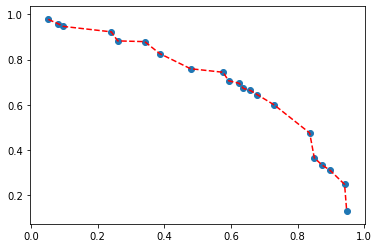

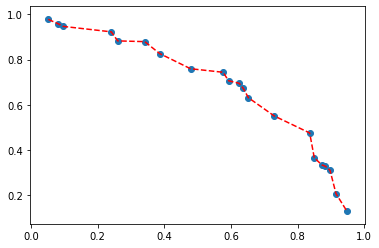

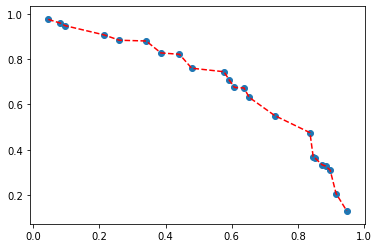

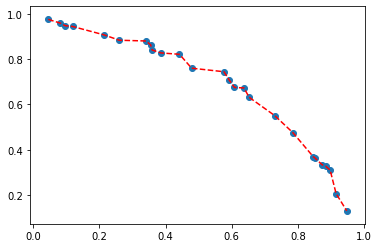

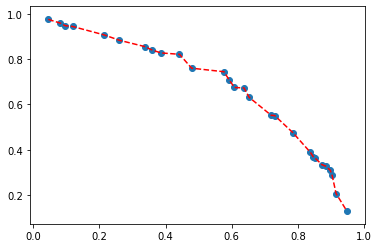

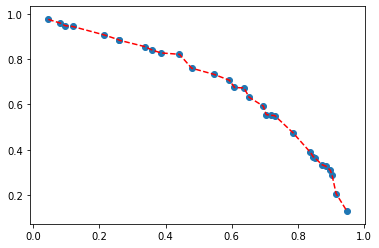

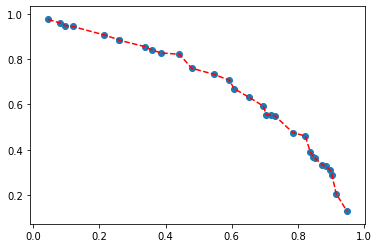

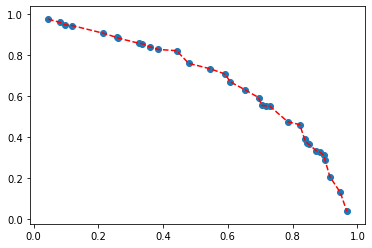

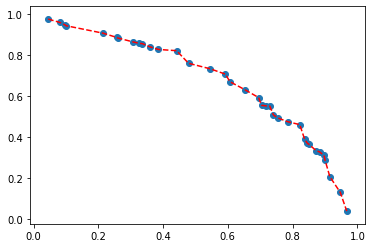

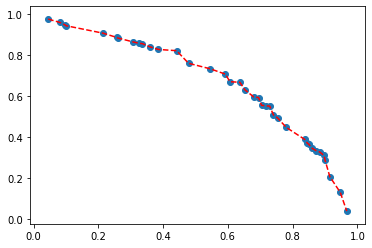

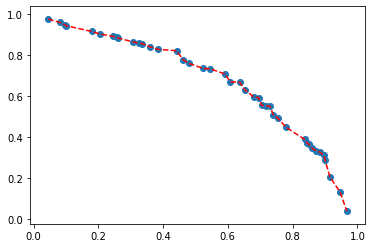

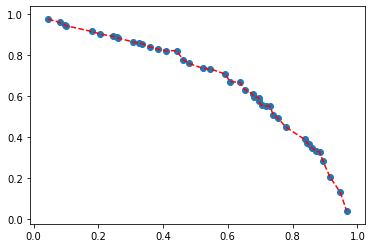

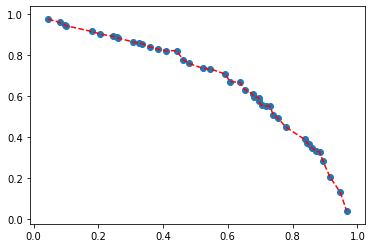

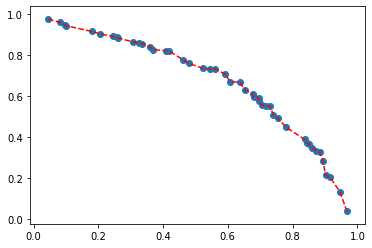

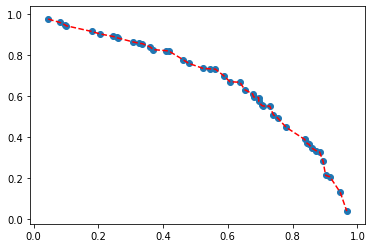

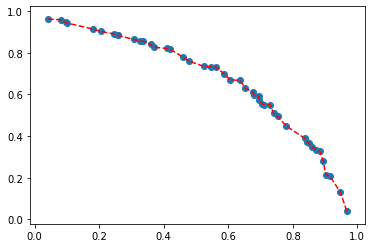

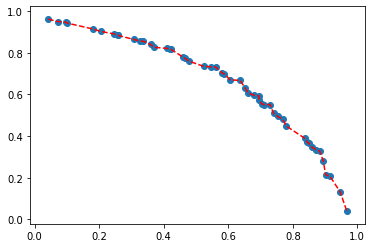

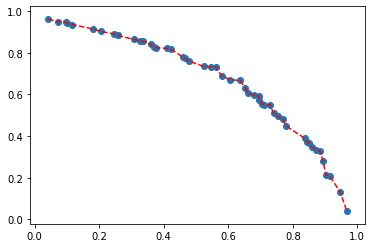

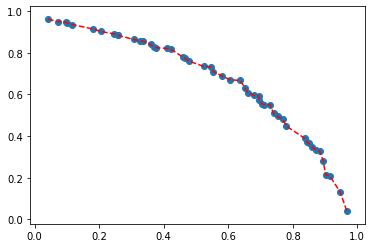

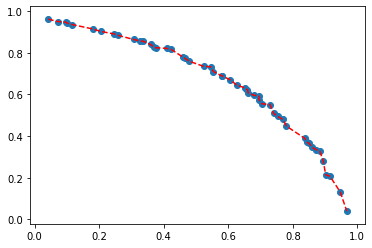

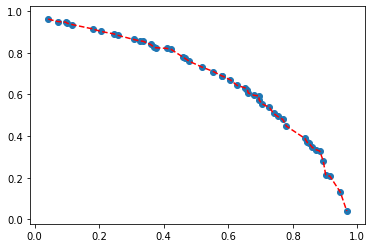

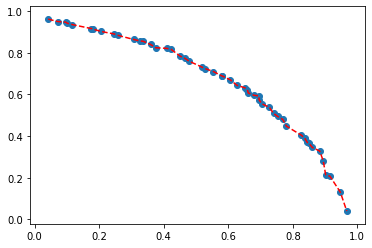

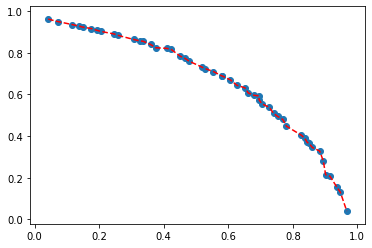

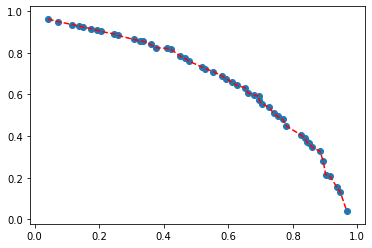

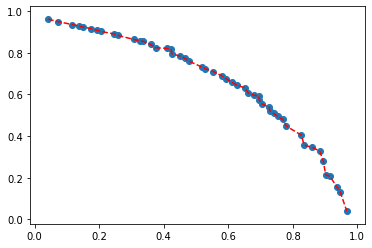

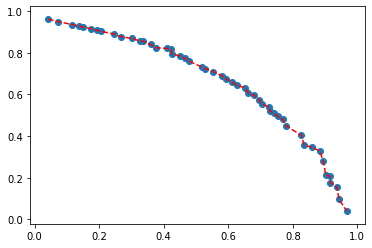

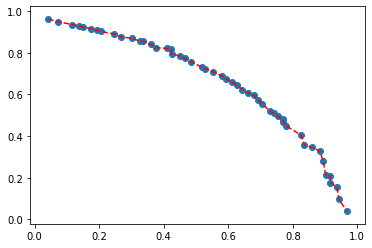

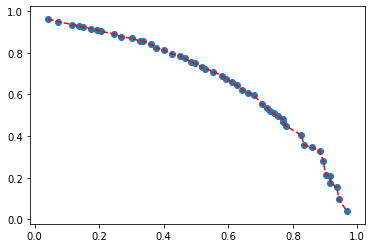

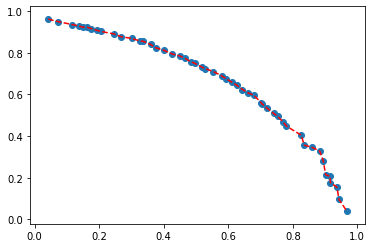

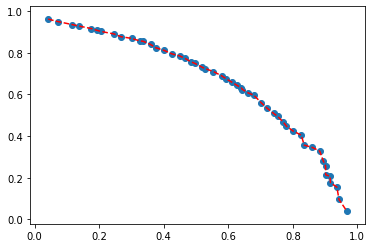

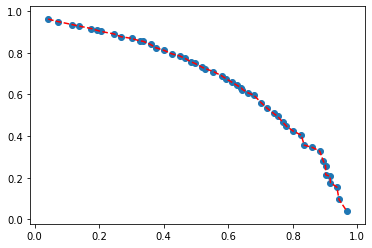

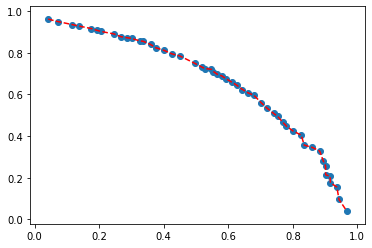

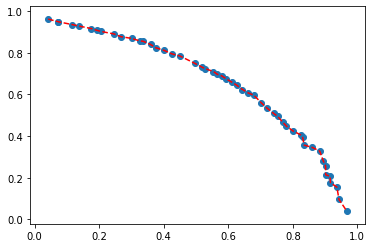

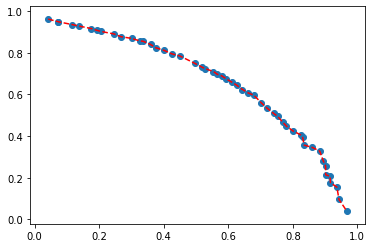

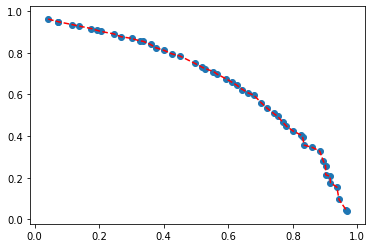

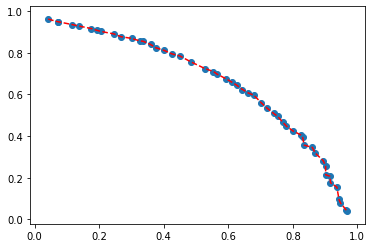

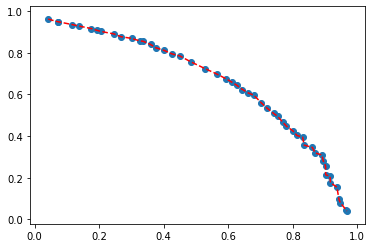

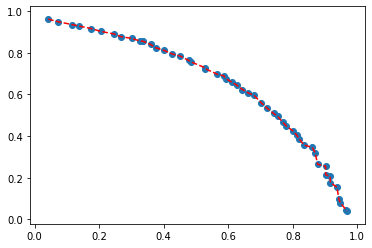

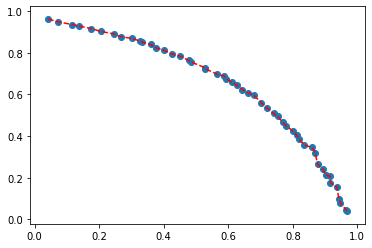

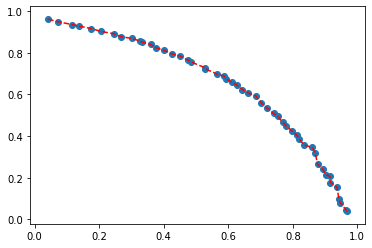

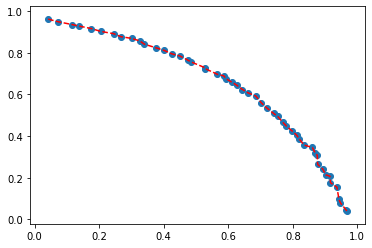

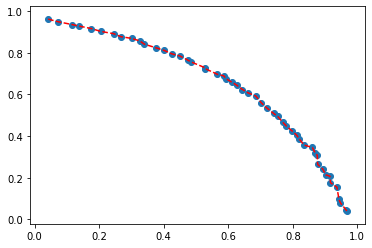

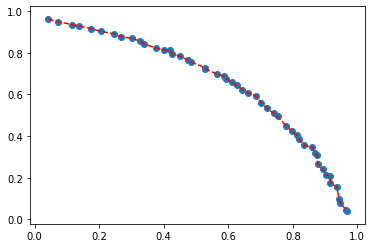

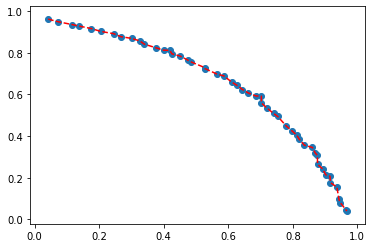

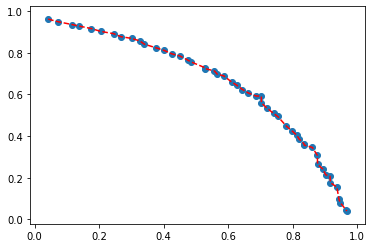

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in double_scalars


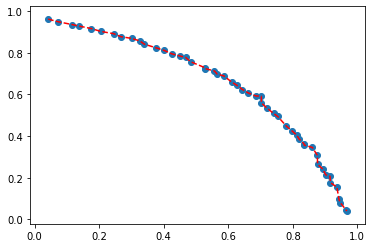

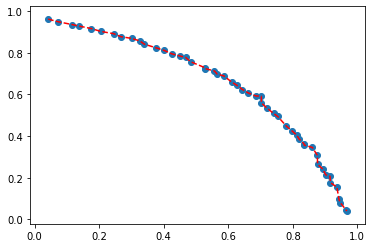

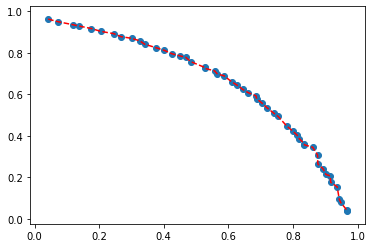

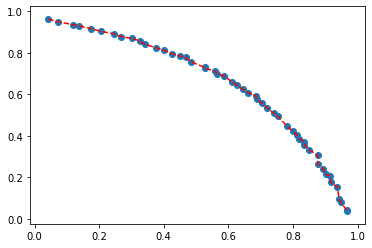

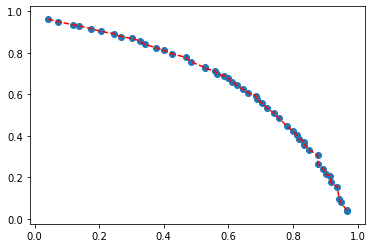

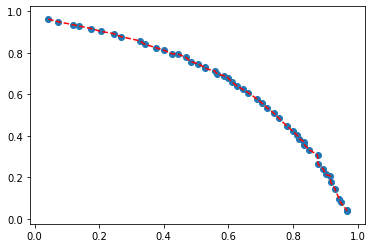

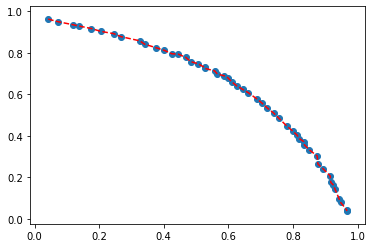

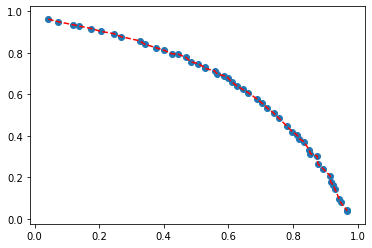

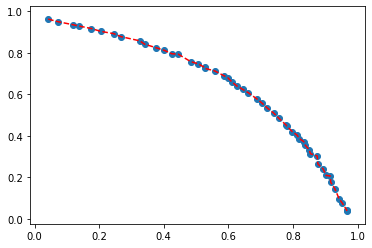

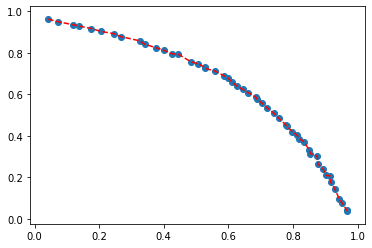

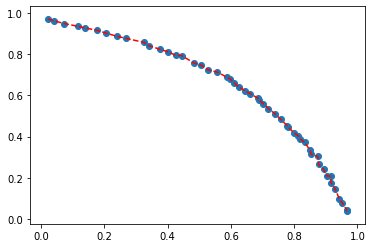

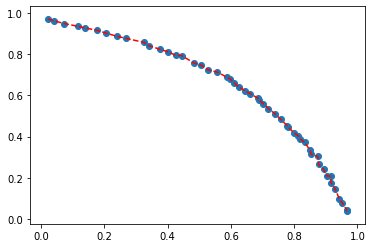

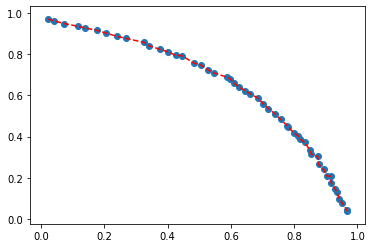

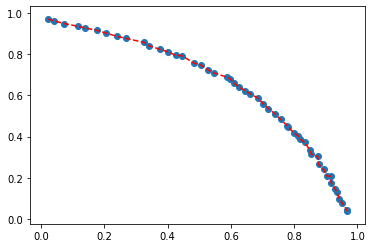

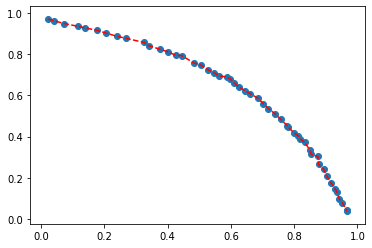

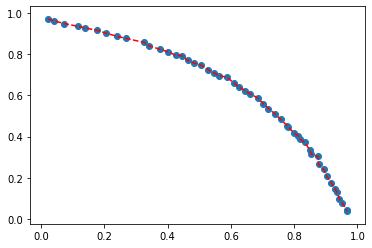

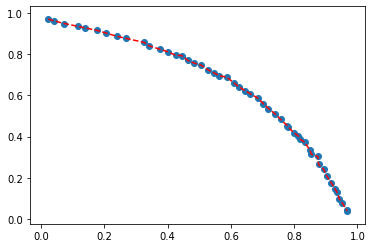

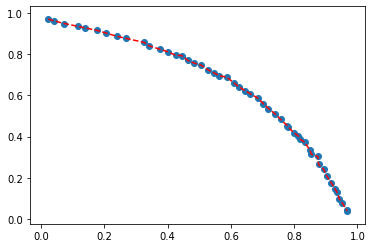

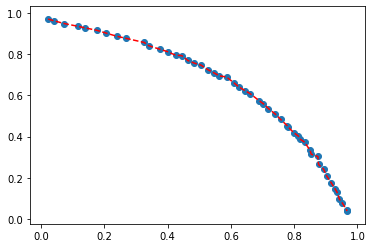

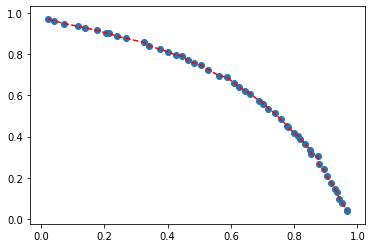

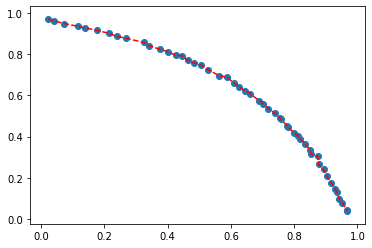

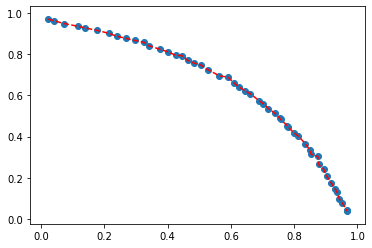

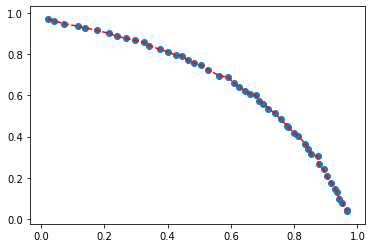

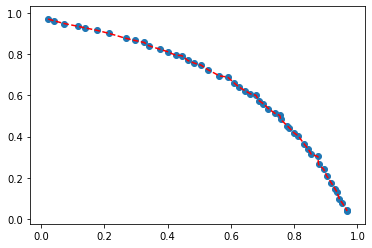

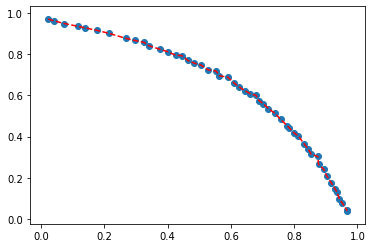

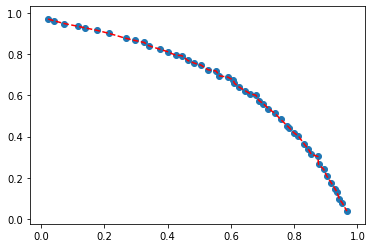

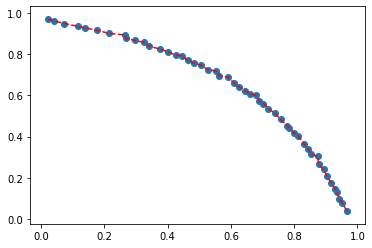

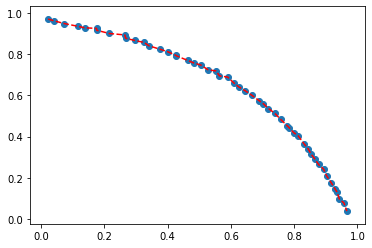

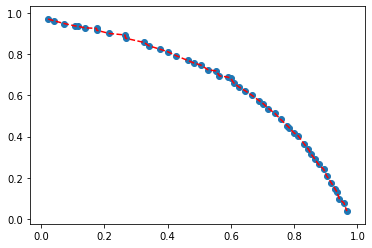

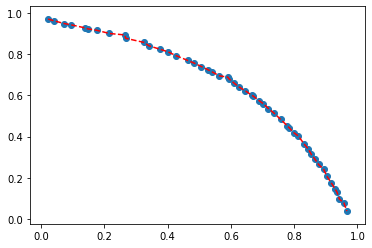

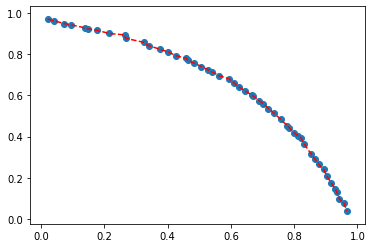

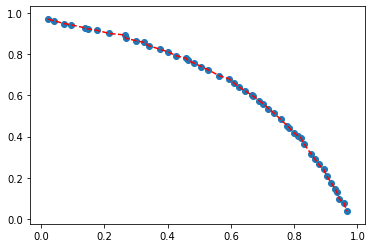

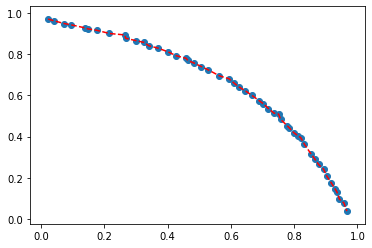

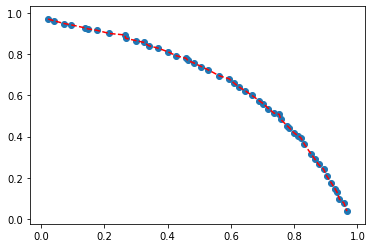

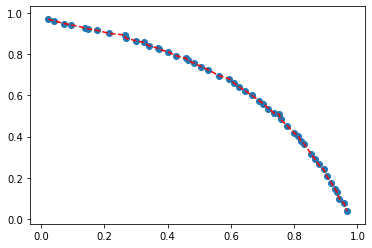

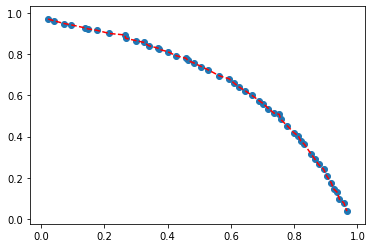

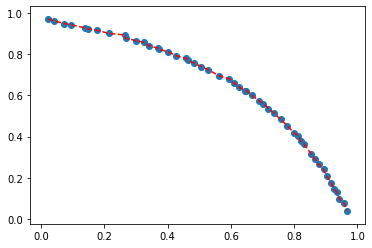

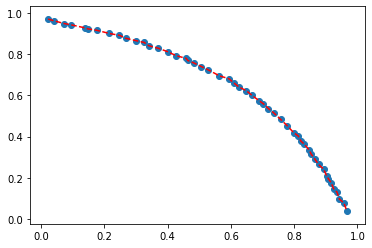

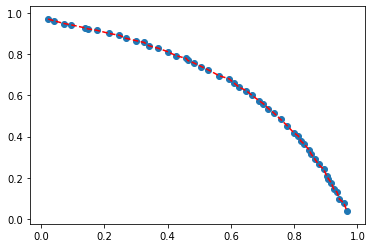

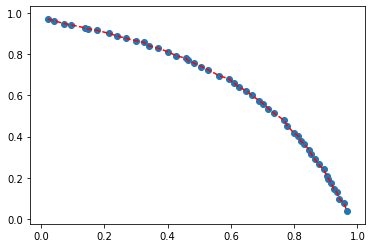

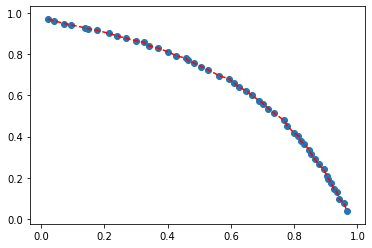

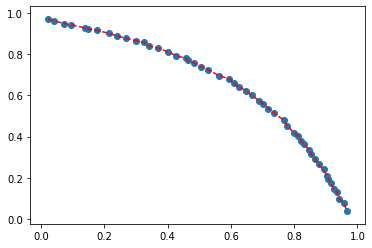

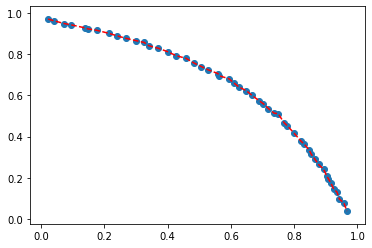

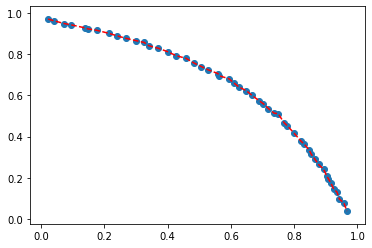

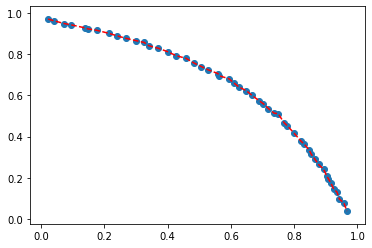

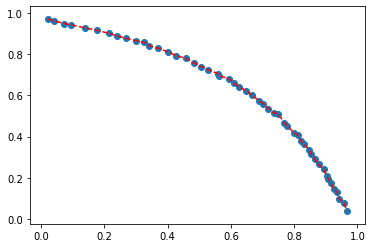

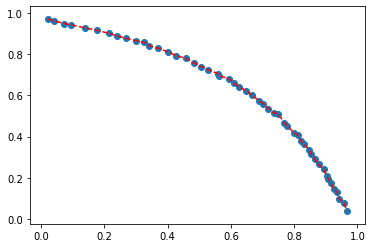

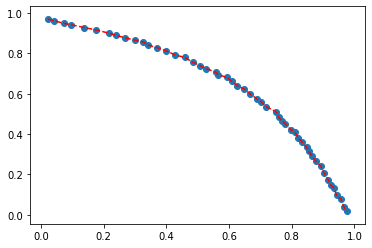

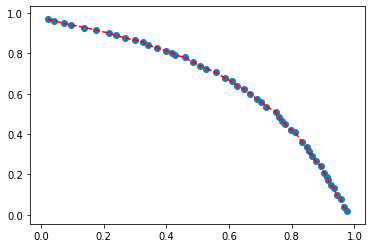

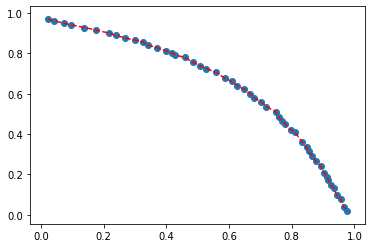

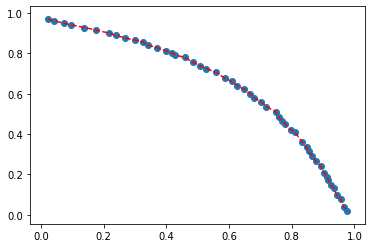

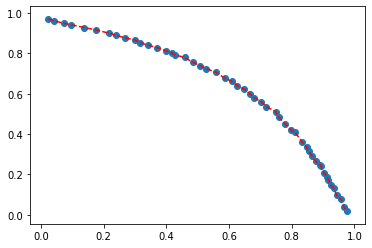

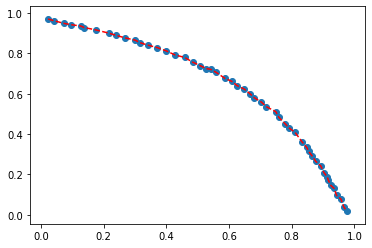

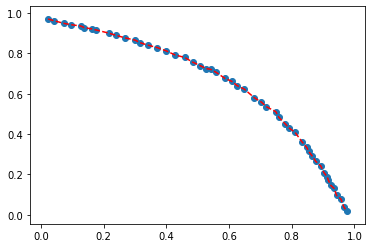

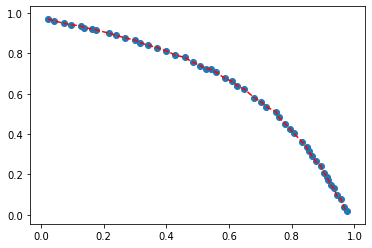

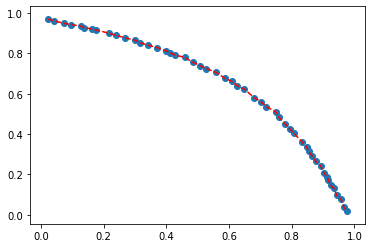

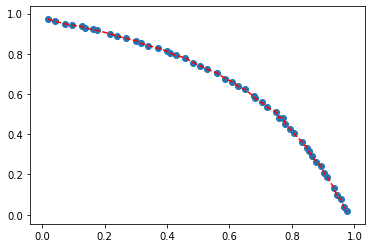

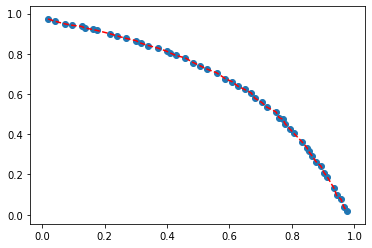

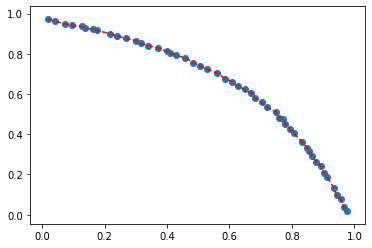

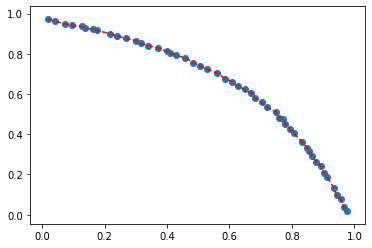

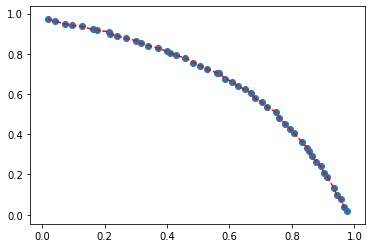

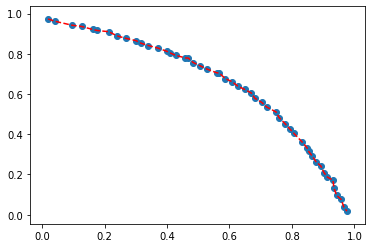

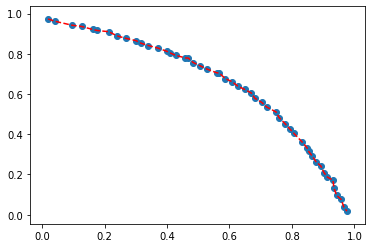

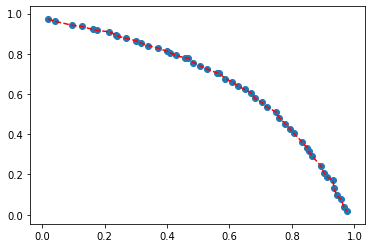

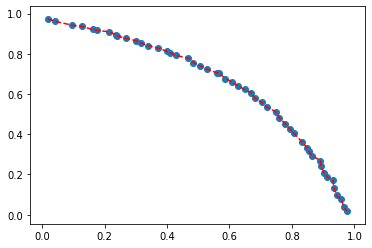

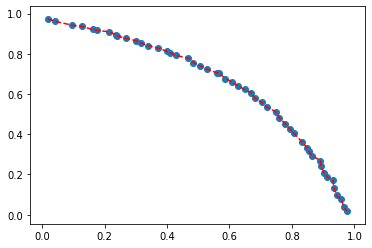

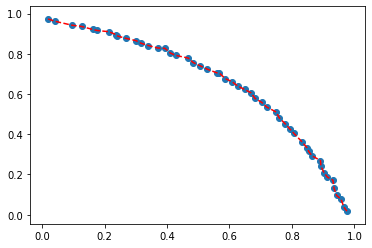

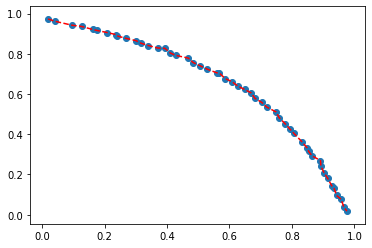

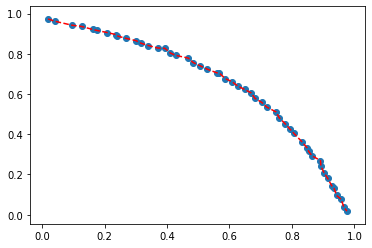

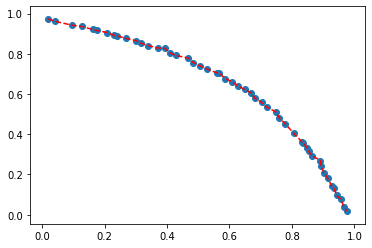

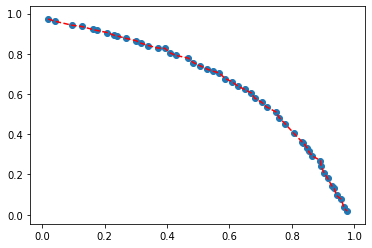

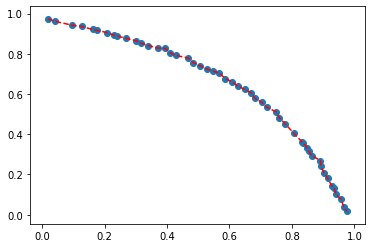

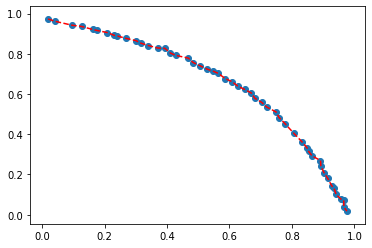

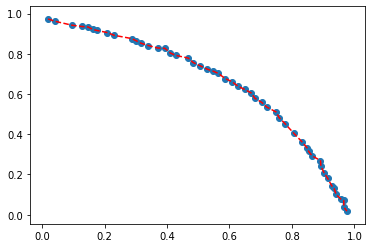

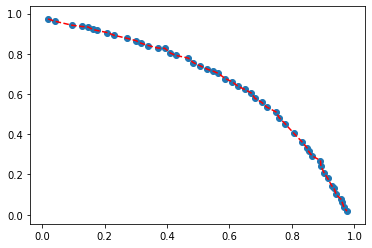

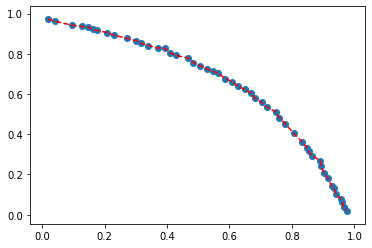

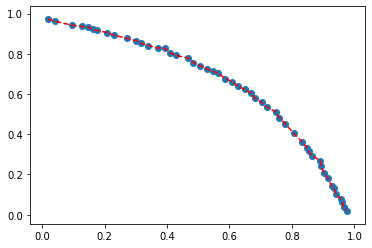

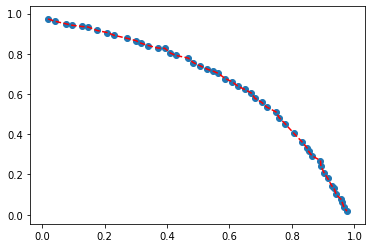

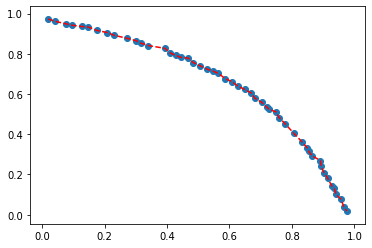

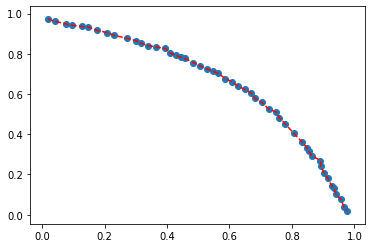

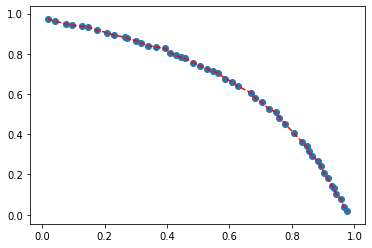

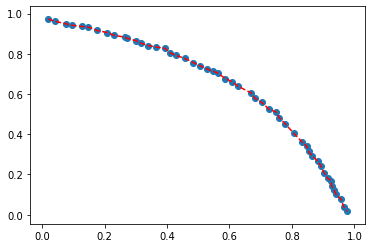

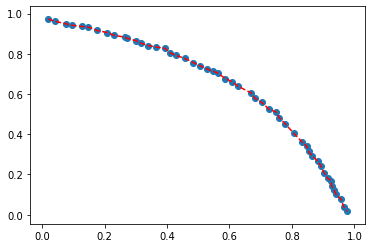

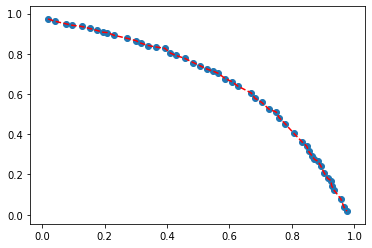

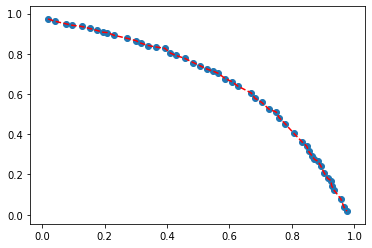

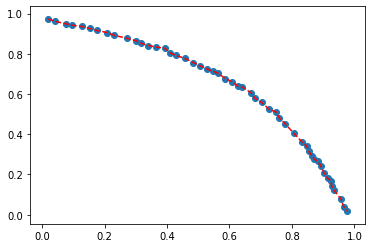

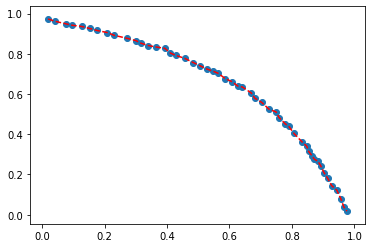

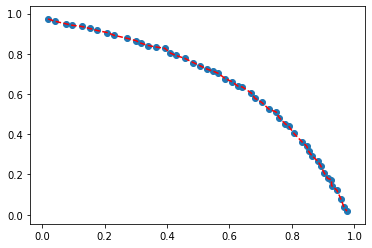

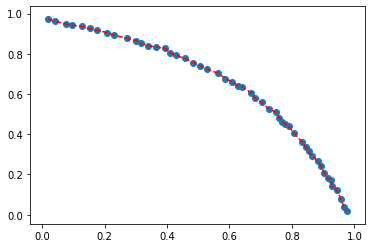

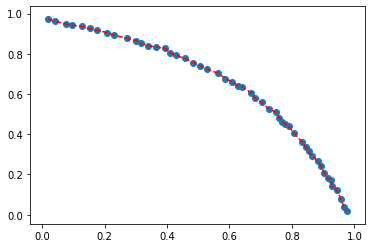

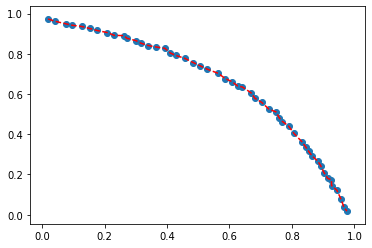

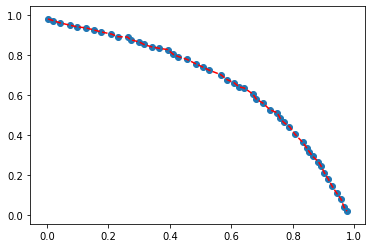

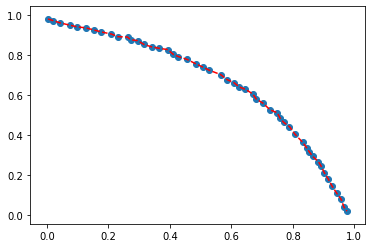

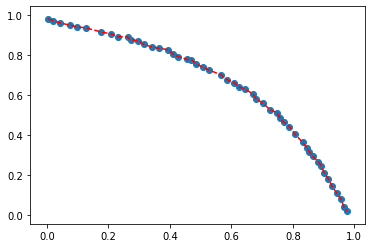

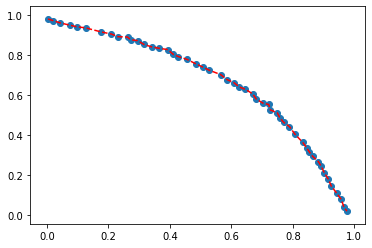

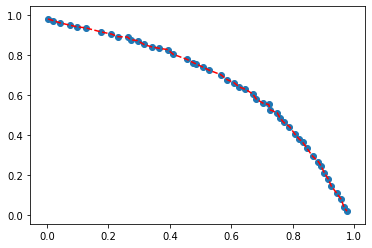

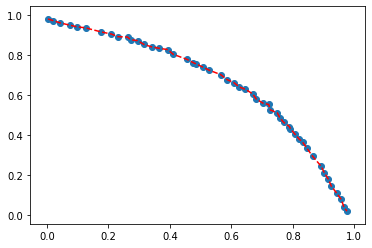

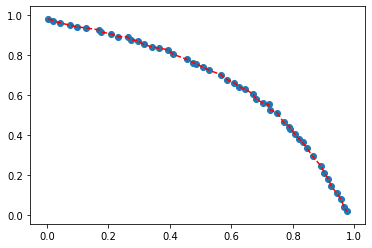

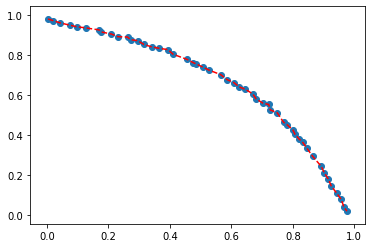

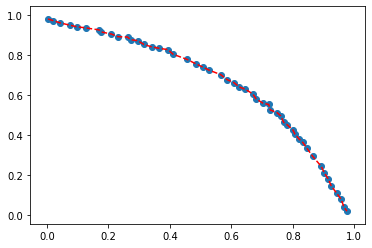

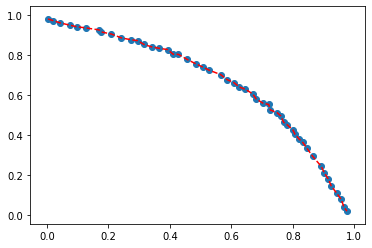

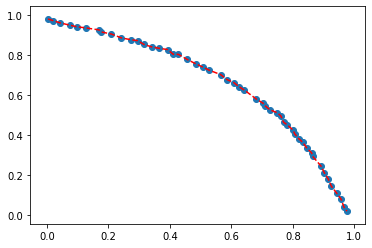

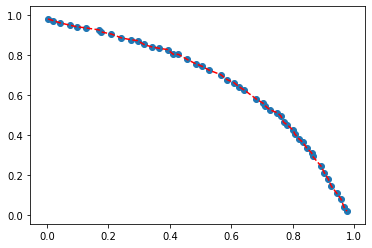

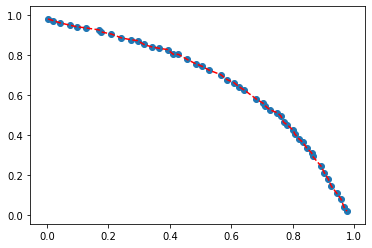

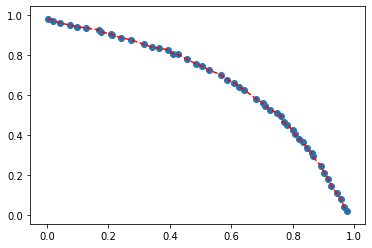

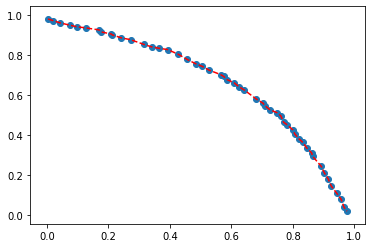

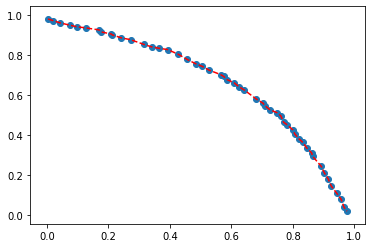

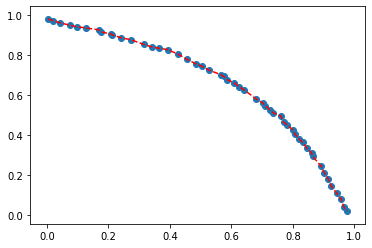

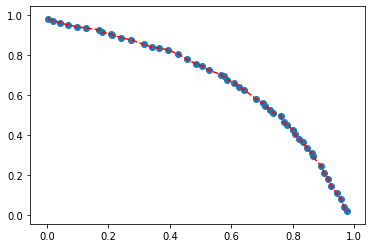

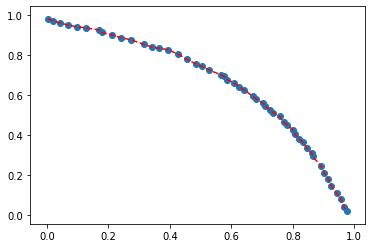

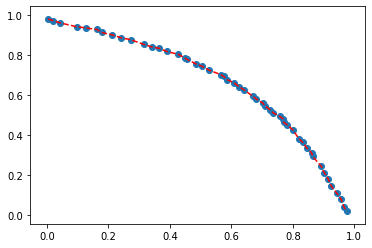

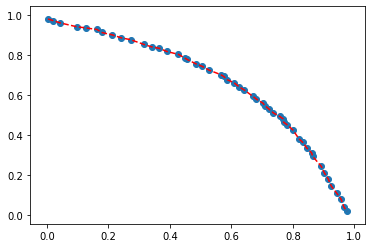

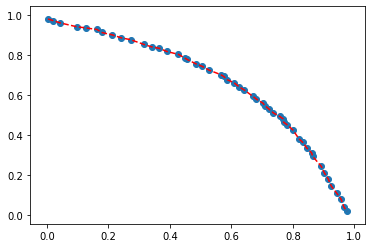

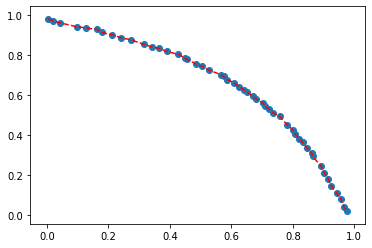

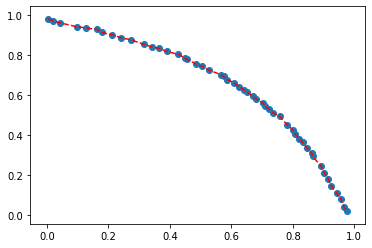

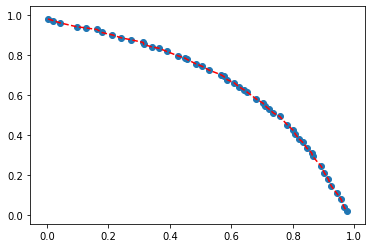

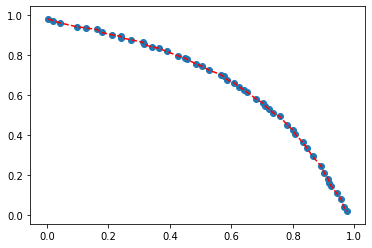

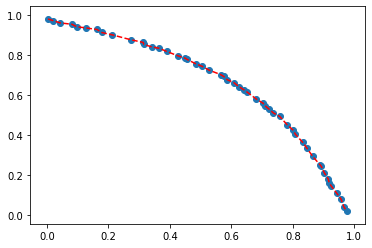

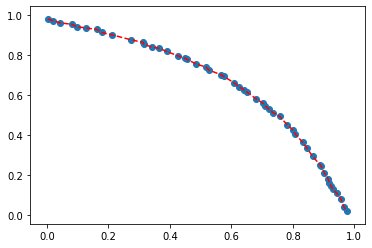

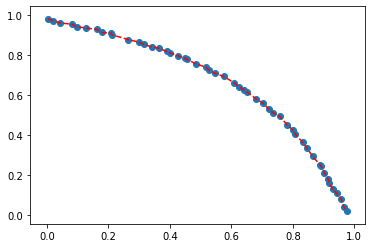

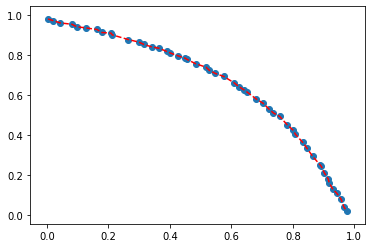

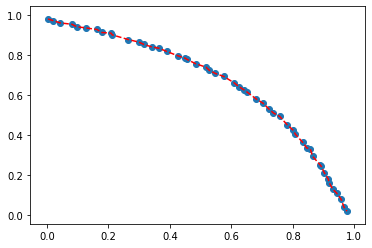

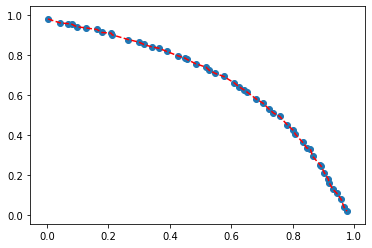

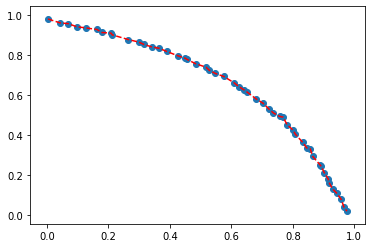

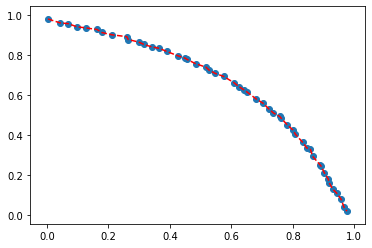

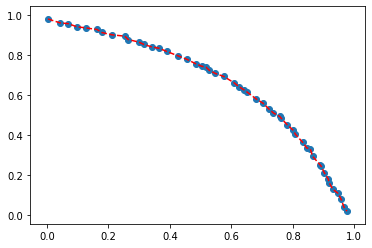

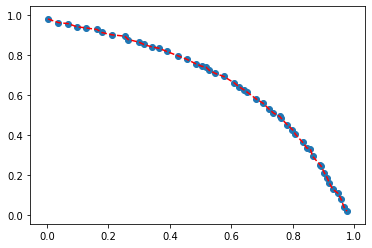

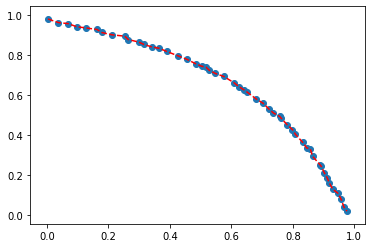

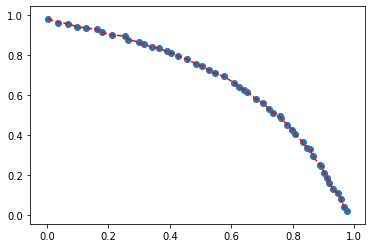

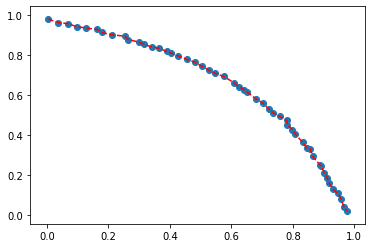

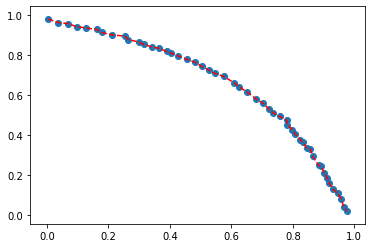

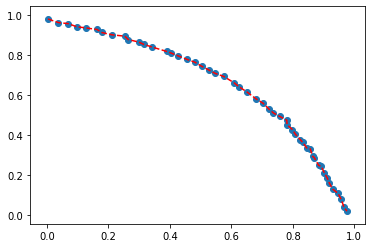

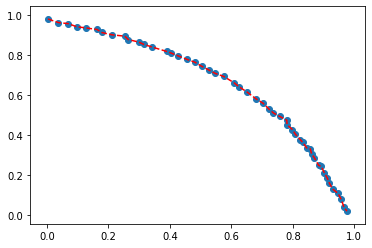

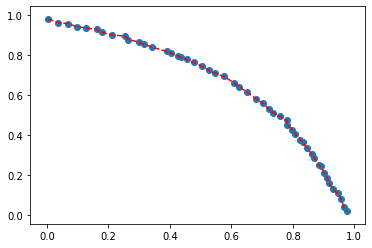

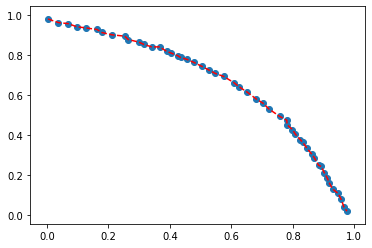

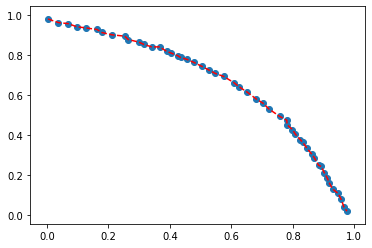

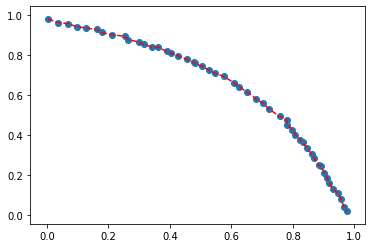

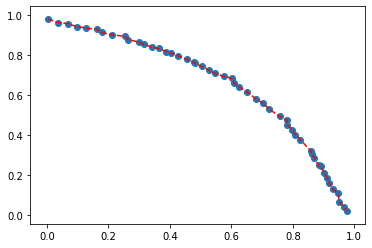

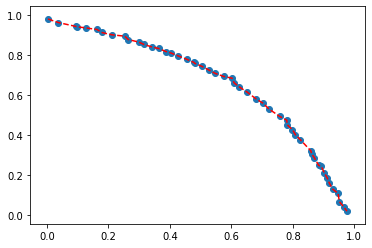

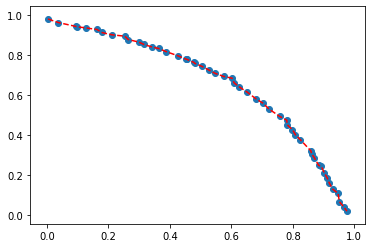

In [40]:
for _ in range(nGeneration):
    Agent.run()